### Goal

Test new ideas of implementing metrics

### TODO
- Imagine genes as a time series - compute the fourier transform and apply pearson corr.

In [78]:
# code autoreload
%load_ext autoreload
%autoreload 2

import random
import math
import numpy.random as nr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import nbinom

import anndata

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# tissues
tissues = ['Adipose - Subcutaneous',
 'Adipose - Visceral (Omentum)',
 'Adrenal Gland',
 'Artery - Aorta',
 'Artery - Coronary',
 'Artery - Tibial',
 'Bladder',
 'Brain - Amygdala',
 'Brain - Anterior cingulate cortex (BA24)',
 'Brain - Caudate (basal ganglia)',
 'Brain - Cerebellar Hemisphere',
 'Brain - Cerebellum',
 'Brain - Cortex',
 'Brain - Frontal Cortex (BA9)',
 'Brain - Hippocampus',
 'Brain - Hypothalamus',
 'Brain - Nucleus accumbens (basal ganglia)',
 'Brain - Putamen (basal ganglia)',
 'Brain - Spinal cord (cervical c-1)',
 'Brain - Substantia nigra',
 'Breast - Mammary Tissue',
 'Cells - EBV-transformed lymphocytes',
 'Cells - Transformed fibroblasts',
 'Cervix - Ectocervix',
 'Cervix - Endocervix',
 'Colon - Sigmoid',
 'Colon - Transverse',
 'Esophagus - Gastroesophageal Junction',
 'Esophagus - Mucosa',
 'Esophagus - Muscularis',
 'Fallopian Tube',
 'Heart - Atrial Appendage',
 'Heart - Left Ventricle',
 'Kidney - Cortex',
 'Liver',
 'Lung',
 'Minor Salivary Gland',
 'Muscle - Skeletal',
 'Nerve - Tibial',
 'Ovary',
 'Pancreas',
 'Pituitary',
 'Prostate',
 'Skin - Not Sun Exposed (Suprapubic)',
 'Skin - Sun Exposed (Lower leg)',
 'Small Intestine - Terminal Ileum',
 'Spleen',
 'Stomach',
 'Testis',
 'Thyroid',
 'Uterus',
 'Vagina',
 'Whole Blood']

In [59]:
def generate_toy_data():
    genes = list(map(lambda x: "Gene_" + str(x) , list(range(1, 1001))))
    distribution_tissues = nr.uniform(1,len(tissues),1000)
    
    # generate samples - raw counts per gene per tissue
    frames = []
    for i in range(1,150): # patients

        # choose tissues
        how_many_tissues = math.floor(distribution_tissues[random.randint(0,len(distribution_tissues))-1])
        random.shuffle(tissues)
        t_set = tissues[:how_many_tissues]  

        # initialize count matrix
        counts = pd.DataFrame(columns=genes,index=map(lambda x: "Patient_" + str(i) + "_" + str(x), t_set))

        for j in range(0,len(t_set)):

            col_name = "Patient_" + str(i) + "_" + t_set[j]

            # generate raw counts per tissue per set of genes
            raw_counts = np.random.negative_binomial(15,0.001,1000)
            counts.loc[col_name] = raw_counts.reshape(1,1000)

        # append expression per tissue for the patient 
        frames.append(counts)


    df_big = pd.concat(frames)
    
    # transpose the matrix to be genes x patient_tissue
    count_matrix = df_big.transpose()
    
    # create annotation dataframes
    # column = 0 its the index! be careful
    samples_anno = pd.DataFrame(index=count_matrix.columns,columns=['Individual','Tissue'])
    gender=[1,2]
    seq=['WGS','WXS']

    for i in range(0,samples_anno.shape[0]):
        sample = samples_anno.index[i]
        [pat,number,tissue] = sample.split("_")

        samples_anno.at[sample, 'Individual'] = pat + "_" + str(number)
        samples_anno.at[sample, 'Tissue'] = tissue
        samples_anno.at[sample, 'Gender'] = gender[int(number)%2]
        samples_anno.at[sample, 'Seq'] = seq[int(number)%2]

    samples_anno.drop_duplicates().shape
    
    genes_anno = pd.DataFrame(index=count_matrix.index)
    
    annobj = anndata.AnnData(count_matrix)
    annobj.var = samples_anno
    annobj.var_names = list(samples_anno.index)
    annobj.obs = genes_anno
    annobj.obs_names = list(genes_anno.index)
    
    return annobj

In [60]:
sample = generate_toy_data()

In [64]:
def compute_baseline(annobj):
    tissues = annobj.var['Tissue'].drop_duplicates().tolist()
    Y_mean_tissue = np.zeros((len(annobj.obs_names),len(tissues)))
    
    for t in tissues:
        slice_bytissue = annobj[:,annobj.var['Tissue'] == t]    
        mean_value = np.log2(np.mean(np.square(slice_bytissue.X),axis=1)+1)
        Y_mean_tissue[:,tissues.index(t)] = mean_value

    
    return pd.DataFrame(data = Y_mean_tissue, index = annobj.obs_names, columns = tissues) 


In [65]:
baseline = compute_baseline(sample)

In [66]:
baseline

,Artery - Coronary,Esophagus - Mucosa,Heart - Left Ventricle,Pituitary,Fallopian Tube,Brain - Spinal cord (cervical c-1),Brain - Cerebellar Hemisphere,Brain - Anterior cingulate cortex (BA24),Brain - Hypothalamus,Brain - Substantia nigra,...,Brain - Cortex,Brain - Caudate (basal ganglia),Muscle - Skeletal,Pancreas,Adipose - Subcutaneous,Cervix - Endocervix,Nerve - Tibial,Colon - Transverse,Breast - Mammary Tissue,Heart - Atrial Appendage
Gene_1,27.885340,27.922901,27.977518,27.919188,27.562105,27.931711,27.795280,27.905949,27.893270,27.834501,...,27.879698,27.900808,27.919313,27.892853,27.859648,27.788429,28.033630,28.051970,27.992004,27.694468
Gene_2,28.039248,27.647516,27.885303,27.876909,27.882719,27.706114,27.644224,27.880739,27.815697,27.735956,...,27.635820,27.887617,27.798553,27.770082,27.789265,27.885025,27.751713,27.879604,27.791679,27.700954
Gene_3,27.869024,27.861450,27.991861,27.891439,27.909492,27.847511,27.914717,27.786364,27.931067,27.837469,...,27.943384,27.883493,27.791605,27.656429,27.906956,27.821249,27.901936,27.822067,27.741999,27.904125
Gene_4,27.804726,27.868799,27.760477,27.648029,27.797638,27.866293,27.934340,27.972626,27.927206,27.825323,...,27.791304,27.847092,27.771002,27.897951,27.842571,27.793806,27.705992,28.028816,27.777672,27.790958
Gene_5,27.747849,27.839577,27.744429,27.922188,27.771614,27.768324,27.785646,27.739744,27.751833,27.619955,...,27.923103,27.737688,27.893349,27.897516,27.901423,27.807087,27.768612,27.900570,27.813147,27.661951
Gene_6,27.975245,27.731451,27.892572,27.801586,27.984909,27.714195,27.707422,27.852083,27.796160,27.854063,...,27.823328,27.848553,27.881411,27.867968,27.742680,27.797123,27.900436,27.766935,27.862934,27.714745
Gene_7,27.901598,27.844767,27.867695,27.621351,27.927431,27.831234,27.874454,27.709286,27.781141,27.802881,...,27.845364,27.861574,27.727398,27.732935,27.814796,27.812250,27.828508,27.796865,27.758627,27.813087
Gene_8,27.833202,27.862181,27.945583,27.648767,27.707901,27.866886,27.822901,27.831944,27.921007,27.732462,...,27.830971,27.684137,27.886314,27.952908,27.832108,27.995878,27.879393,27.842024,27.796255,27.826681
Gene_9,27.787390,27.738886,27.776646,27.793470,27.872534,27.866169,27.685286,27.945158,27.822926,27.888788,...,27.825451,27.760363,27.853895,27.918171,27.857645,27.815689,27.798910,27.777559,27.835468,27.877628
Gene_10,27.867830,27.859241,27.808033,27.920609,27.880476,27.859007,27.775599,28.004229,27.735786,27.843870,...,27.789158,27.929661,27.873974,27.784660,27.924004,27.766634,27.820904,27.934959,27.962709,27.810963


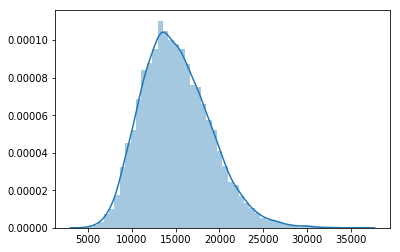

In [56]:
x = np.random.negative_binomial(15,0.001,10000)
sns.distplot(x)

In [70]:
slice_bytissue = np.arange(10,3)
slice_bytissue

array([], dtype=int64)

In [72]:
np.log2(np.mean(np.square(slice_bytissue),axis=1)+1)

IndexError: tuple index out of range

In [73]:
import joblib

In [74]:
?joblib.dump

Signature: joblib.dump(value, filename, compress=0, protocol=None, cache_size=None)
Docstring:
Persist an arbitrary Python object into one file.

Read more in the :ref:`User Guide <persistence>`.

Parameters
-----------
value: any Python object
    The object to store to disk.
filename: str, pathlib.Path, or file object.
    The file object or path of the file in which it is to be stored.
    The compression method corresponding to one of the supported filename
    extensions ('.z', '.gz', '.bz2', '.xz' or '.lzma') will be used
    automatically.
compress: int from 0 to 9 or bool or 2-tuple, optional
    Optional compression level for the data. 0 or False is no compression.
    Higher value means more compression, but also slower read and
    write times. Using a value of 3 is often a good compromise.
    See the notes for more details.
    If compress is True, the compression level used is 3.
    If compress is a 2-tuple, the first element must correspond to a string
    between suppo

In [75]:
from sklearn.pipeline import Pipeline

In [77]:
import pickle
?pickle.dumps

Signature: pickle.dumps(obj, protocol=None, *, fix_imports=True)
Docstring:
Return the pickled representation of the object as a bytes object.

The optional *protocol* argument tells the pickler to use the given
protocol; supported protocols are 0, 1, 2, 3 and 4.  The default
protocol is 3; a backward-incompatible protocol designed for Python 3.

Specifying a negative protocol version selects the highest protocol
version supported.  The higher the protocol used, the more recent the
version of Python needed to read the pickle produced.

If *fix_imports* is True and *protocol* is less than 3, pickle will
try to map the new Python 3 names to the old module names used in
Python 2, so that the pickle data stream is readable with Python 2.
Type:      builtin_function_or_method


In [84]:
# load gtex summarized experiment
import rep.preprocessing as p
import os
path = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","input_data")

In [88]:
x_train = p.readh5(os.path.join(path,'X_train_pc.h5'))

In [90]:
y_train =  p.readh5(os.path.join(path,'Y_train_pc.h5'))

In [97]:
p.writeh5(x_train[:1000,:100],"xtrain","xtrain_mock.h5")

In [98]:
p.writeh5(y_train[:1000,:100],"ytrain","ytrain_mock.h5")

In [99]:
p.writeh5(x_train[1000:2000,:100],"xvalid","xvalid_mock.h5")
p.writeh5(y_train[1000:2000,:100],"yvalid","yvalid_mock.h5")

In [100]:
os.getcwd()

'/data/nasif12/home_if12/giurgiu/rep_gagneur/rep/notebooks/tutorials'

In [101]:
x_train[1000:2000,:100]

array([[5.5899897, 3.195069 , 5.218777 , ..., 4.6731405, 3.935608 ,
        5.650378 ],
       [5.5899897, 3.195069 , 5.218777 , ..., 4.6731405, 3.935608 ,
        5.650378 ],
       [5.5899897, 3.195069 , 5.218777 , ..., 4.6731405, 3.935608 ,
        5.650378 ],
       ...,
       [4.8776016, 3.2605484, 4.9322047, ..., 4.795595 , 3.8667006,
        5.5314136],
       [4.8776016, 3.2605484, 4.9322047, ..., 4.795595 , 3.8667006,
        5.5314136],
       [4.8776016, 3.2605484, 4.9322047, ..., 4.795595 , 3.8667006,
        5.5314136]], dtype=float32)